In [2]:
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from time import time
import os

from deepdecoder import DeepDecoder
from training import train
from sampling import langevin_sample
from utils import *

import matplotlib.pyplot as plt

# Load the data

In [4]:
name = 'noisy_astro'
img_path = f"data/{name}.png"
y = load_img(img_path) # Tensor of shape (1,k_out,512,512)
k_out = y.shape[1]

In [6]:
# Decide the number of channels of the DeepDecoder
k = 64
# Select device ('cuda', 'cpu', 'mps', ...)
device = 'cpu'

### For reproducibility, we provide here a set of input tensor for different values of k (contained in the folder 'data')

In [8]:
model = DeepDecoder(k=k,k_out=3)
z = torch.load(f'data/z{k}.pt')

# Pre-train the model

In [9]:
path = f'outputs/{name}_{k}k'
os.makedirs(f'{path}/reconstructions', exist_ok=True)
save_path = f'{path}/initial_train_model.pt'

loss_fct = get_loss_function()
optimizer = get_optimizer(model,lr=0.01, weight_decay=0.02)

In [10]:
torch.manual_seed(0)
t = time()
log_loss = train(model,
                 z,
                 img=y,
                 num_epochs=2000,
                 criterion=loss_fct,
                 optimizer=optimizer,
                 device=device,
                 save_path=save_path,
                 verbose=True)
print('Training time:', time()-t, 's')

Training on device: cpu
Iteration: 9
Training finished
Training time: 4.13753080368042 s


# Visualize reconstruction after training

In [11]:
recon_init_train = reconstruct(z,model,device=device)
recon_init_train.show()
recon_init_train.save(f'{path}/reconstructions/initial_train_recon.png')

In [12]:
losses_init_train = log_loss['train_loss']
#losses_init_train_np = np.array(losses_init_train)
#np.save(f'{path}/initial_training_loss.npy',losses_init_train_np)

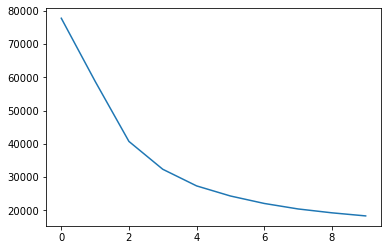

In [13]:
plt.plot(losses_init_train)

# Sampling

### Note that the langevin_sample function only saves the last 20% of the total samples extracted

In [14]:
model.load_state_dict(torch.load(f'{path}/initial_train_model.pt',
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
torch.manual_seed(1)
t = time()
log_samples = langevin_sample(model=model,
                      z=z,
                      img=y,
                      num_samples_wanted=1000,
                      prior='l2',
                      lr=0.002,
                      sigma=0.707106781,
                      nu=7.071067812,
                      device=device,
                      debug=False,
                      verbose=True)
print('Sampling time:', time()-t, 's')

Sampling on device: cpu
Samples extacted: 10     Total iterations: 13
Sampling finished
Acceptance rate: 0.7692307692307693
Sampling time: 10.38494086265564 s


In [16]:
thetas = log_samples['thetas']
print('Samples saved:',len(thetas))

losses = log_samples['losses']
#losses_np = np.array(losses)

#total_losses = log_samples['total_losses']
#total_losses_np = np.array(total_losses)

#ratios = log_samples['ratios']
#atios_np = np.array(ratios)

torch.save(thetas,f'{path}/theta_samples.pt')
#np.save(f'{path}/theta_samples_loss.npy',losses_np)
#np.save(f'{path}/theta_samples_total_loss.npy',total_losses_np)
#np.save(f'{path}/theta_samples_ratios.npy',ratios)

Samples saved: 1


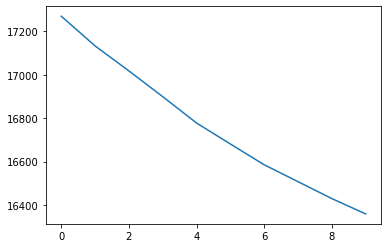

In [17]:
plt.plot(losses)

# Visualize reconstruction from a sample

In [20]:
theta = thetas[0]
nn.utils.vector_to_parameters(theta,model.parameters())
recon_sample = reconstruct(z,model,device=device)
recon_sample.show()
recon_sample.save(f'{path}/reconstructions/recon_from_sample.png')

# Retrain model from each sample selected

In [21]:
os.makedirs(f'{path}/retrained_models', exist_ok=True)
os.makedirs(f'{path}/retrained_losses', exist_ok=True)

In [22]:
#Select samples
thetas_cut = thetas[:]
new_thetas = list()
for i, theta in enumerate(thetas_cut):
    if i%2==0:
        new_thetas.append(theta)
print('Number of samples selected:',len(new_thetas))

Number of samples selected: 1


In [24]:
torch.manual_seed(2)
t = time()
for i, theta in enumerate(new_thetas):
    print('Training from sample num.',i,end='\r')
    nn.utils.vector_to_parameters(theta,model.parameters())
    optimizer = get_optimizer(model,lr=0.01, weight_decay=0.02)
    save_path = f'{path}/retrained_models/model_{i:04d}.pt'
    log_loss = train(model,
                     z,
                     img=y,
                     num_epochs=500,
                     criterion=loss_fct,
                     optimizer=optimizer,
                     device=device,
                     save_path=save_path,
                     verbose=False)
    losses = log_loss['train_loss']
    np.save(f'{path}/retrained_losses/loss_{i:04d}.npy', losses)
print('\nRetraining time:', time()-t, 's')

Training from sample num. 0
Retraining time: 2.011805772781372 s


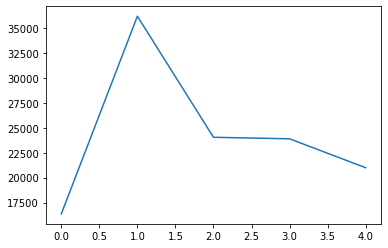

In [25]:
losses = np.load(f'{path}/retrained_losses/loss_0000.npy')
plt.plot(losses)

# Compute average reconstructions

In [26]:
if k_out == 1:
    img_sum1 = np.zeros((512,512))
    img_sum2 = np.zeros((512,512))
    img_sum3 = np.zeros((512,512))
elif k_out == 3:
    img_sum1 = np.zeros((512,512,3))
    img_sum2 = np.zeros((512,512,3))
    img_sum3 = np.zeros((512,512,3))

j,k = 0,0
for i in range(len(new_thetas)):
    model.load_state_dict(torch.load(f'{path}/retrained_models/model_{i:04d}.pt',
                                     map_location=torch.device(device)))
    img = reconstruct(z,model,device=device)
    img.save(f'{path}/reconstructions/recon_{i:04}.png')
    img = np.array(img)
    img_sum3 += img
    if i>=int(0.5*len(new_thetas)):
        img_sum2 += img
        j+=1
    if i>=int(0.8*len(new_thetas)):
        img_sum1 += img
        k+=1

img_avg1 = img_sum1/k
img_avg1 = img_avg1.astype('uint8')
img_avg1 = Image.fromarray(img_avg1)
img_avg2 = img_sum2/j
img_avg2 = img_avg2.astype('uint8')
img_avg2 = Image.fromarray(img_avg2)
img_avg3 = img_sum3/len(new_thetas)
img_avg3 = img_avg3.astype('uint8')
img_avg3 = Image.fromarray(img_avg3)
if k_out == 1:
    img_avg1 = img_avg1.convert('L')
    img_avg2 = img_avg2.convert('L')
    img_avg2 = img_avg2.convert('L')
elif k_out == 3:
    img_avg1 = img_avg1.convert('RGB')
    img_avg2 = img_avg2.convert('RGB')
    img_avg3 = img_avg3.convert('RGB')

img_avg1.save(f'{path}/reconstructions/AVG_1.png')
img_avg2.save(f'{path}/reconstructions/AVG_2.png')
img_avg3.save(f'{path}/reconstructions/AVG_3.png')

# Compare results and compute PSNR

In [27]:
clean_img = load_img_np('data/astronaut.png')
noisy_img = load_img_np('data/noisy_astro.png')
recon_init_train = load_img_np(f'{path}/reconstructions/initial_train_recon.png')
recon_avg1 = load_img_np(f'{path}/reconstructions/AVG_1.png')
recon_avg2 = load_img_np(f'{path}/reconstructions/AVG_2.png')
recon_avg3 = load_img_np(f'{path}/reconstructions/AVG_3.png')
recon_from_sample = load_img_np(f'{path}/reconstructions/recon_from_sample.png')

In [28]:
psnr_noisy = psnr(noisy_img,clean_img)
psnr_init_train = psnr(recon_init_train,clean_img)
psnr_avg1 = psnr(recon_avg1,clean_img)
psnr_avg2 = psnr(recon_avg2,clean_img)
psnr_avg3 = psnr(recon_avg3,clean_img)
psnr_sample = psnr(recon_from_sample, clean_img)

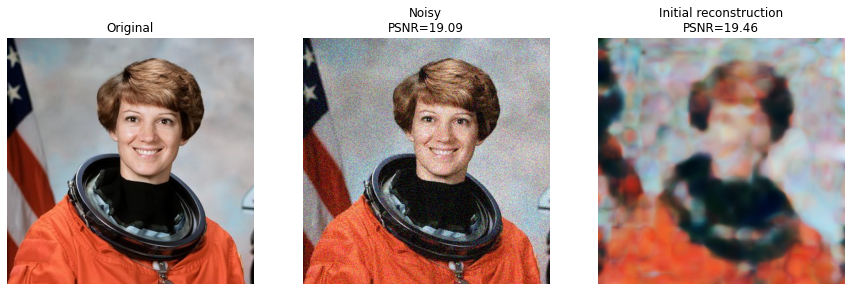

In [29]:
fig,axs = plt.subplots(1,3,figsize=(15,10))
for ax in axs:
    ax.axis('off')
axs[0].imshow(clean_img)
axs[0].title.set_text(f'Original')
axs[1].imshow(noisy_img)
axs[1].title.set_text(f'Noisy\nPSNR={psnr_noisy:.2f}')
axs[2].imshow(recon_init_train)
axs[2].title.set_text(f'Initial reconstruction\nPSNR={psnr_init_train:.2f}')

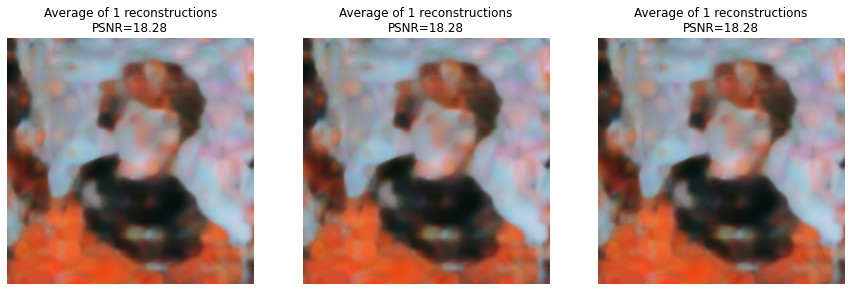

In [31]:
fig,axs = plt.subplots(1,3,figsize=(15,10))
for ax in axs:
    ax.axis('off')
axs[0].imshow(recon_avg1)
axs[0].title.set_text(f'Average of {k} reconstructions\nPSNR={psnr_avg1:.2f}')
axs[1].imshow(recon_avg2)
axs[1].title.set_text(f'Average of {j} reconstructions\nPSNR={psnr_avg2:.2f}')
axs[2].imshow(recon_avg3)
axs[2].title.set_text(f'Average of {len(new_thetas)} reconstructions\nPSNR={psnr_avg3:.2f}')

Text(0.5, 1.0, 'Reconstruction from sample \n PSNR=20.15')

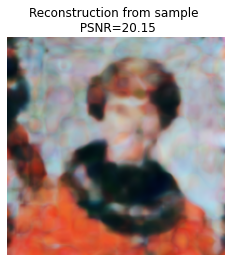

In [32]:
plt.axis('off')
plt.imshow(recon_from_sample)
plt.title(f'Reconstruction from sample \n PSNR={psnr_sample:.02f}')